In [1]:
import pandas as pd

import os
os.chdir('E:/Master-thesis/7. source code/LiClipse/HDDR-Viz/src')
import viz
import EMordering
import dataio
import TSPmeans
#import main
import metrics
from time import gmtime, strftime
import timeit

print dataio.sources_dict.keys()
output_dir='E:/Master-thesis/output/evaluation/'


['golub', 'iris', 'wdbc', 'yeast', 'cars', 'abalone', 'income', 'alon', 'aaup', 'parkinson', 'waveform', 'bike', 'traffic', 'community', 'auto', 'olive', 'magic', 'noisy_wave', 'subway', 'wine']


In [3]:
def append_data(log_df,params):
    
    tasks_list=[]
    ordering_list=[]
    param_list=[]
    #print 'i am there'
    for ordering_method in params['ordering_methods']:
        
        for task in params['tasks']:         
            if task=='viz':
                param_list.append(params['viz_method'])
            elif task=='ordering':
                param_list.append(params['ordering_direction'])
            else:
                continue
            ordering_list.append(ordering_method)
            tasks_list.append(task)
        
    appended_rows=len(tasks_list)
    dataset_list=[params['data_source'] for i in range(appended_rows)]
    current_time=strftime("%Y-%m-%d %H:%M:%S", gmtime())
    #print current_time
    time_list=[current_time for i in range(appended_rows)]
    df=pd.DataFrame({'dataset':dataset_list,'task':tasks_list,'ordering':ordering_list,'param':param_list,'time':time_list})
    
    log_df=log_df.append(df,ignore_index=True)
    #print df
    #print log_df
    return log_df

def check_csv(output_name,ordering_direction,ordering_methods,dataset_name):
    res=[]
                
    #print output_name,ordering_direction,ordering_methods
    for ordering_method in ordering_methods:
        if dataset_name=='magic' or dataset_name=='bike':
            if ordering_method=='HColo' or ordering_method=='LK' or ordering_method=='MDS':
                continue
        csv_name=output_name+'_'+ordering_method+'_'+ordering_direction+'.csv'
        if not os.path.isfile(csv_name):
            res.append(ordering_method)
    return res

def check_png(output_name,viz_method,ordering_methods,dataset_name):
    res=[]

    
    for ordering_method in ordering_methods:
        if dataset_name=='magic' or dataset_name=='bike':
            if ordering_method=='HColo' or ordering_method=='LK' or ordering_method=='MDS':
                continue
        png_name=output_name+'_'+ordering_method+'_'+viz_method+'.png'
        if not os.path.isfile(png_name):
            res.append(ordering_method)
    return res

def check_metrics(dataset,metrics,ordering_method):
    res=[]
    df=pd.read_csv(metrics_file,header=0)
    for metric in metrics:
        if ((df['dataset'] == dataset) & (df['metric'] == metric) & (df['ordering'] == ordering_method)).any():
            continue
        else:
            res.append(ordering_method)
    return res

def save_metric(dataset,metric,parameter,value):
    metrics_df=pd.read_csv(metrics_file,header=0)
    
        


log_file='E:/Master-thesis/output/evaluation/log.csv' #store results
metrics_file='E:/Master-thesis/output/evaluation/metrics.csv'
log_df=pd.read_csv(log_file,header=0)


#WHAT we need to have
#datasets_all=['auto']
datasets_all=[ 'traffic']
#datasets_all=dataio.sources_dict.keys()
ordering_methods_all=['TSNE','random','TSPmeans','EM','EMmanhattan','HColo','LK','MDS']
ordering_directions_all=['rows','cols']
viz_methods_all=['heatmap']


for dataset_name in datasets_all:
    #try:
    
    if dataset_name=='traffic':
        alias='traffic3000'
    elif dataset_name=='parkinson':
        alias='parkinsons'
    elif dataset_name=='community':
        alias='communities'
    elif dataset_name=='olive':
        alias='oliveoil'   
    elif dataset_name=='noisy_wave':
        alias='waveform_noise'  
    else:
        alias=dataset_name
    #output_name=output_dir+alias+'/'+alias
        

    print 'Working with dataset:',dataset_name

    #check and create folder
    directory = output_dir+dataset_name
    #print directory
    if not os.path.exists(directory):
        os.makedirs(directory)

    #find what we need to do

    #dataset_name='iris'
    params={
    'data_source_type':'load',
    'data_source':dataset_name,
    'viz_method':'heatmap',
    'ordering_methods':['original'],
    'output_name':output_dir+alias+'/'+alias,
    }

    #reordering 
    start_time = timeit.default_timer()
    params['tasks']=['ordering']

    for ordering_direction in ordering_directions_all:
        params['ordering_direction']=ordering_direction
        if ordering_direction=='cols':
            params['viz_method']='PC'
        else:
            params['viz_method']='heatmap'

        if ordering_direction=='cols' and dataset_name=='ch130':
            continue

        #check which csv are already there and return list of not existing
        params['ordering_methods']=check_csv(params['output_name'],ordering_direction,ordering_methods_all,dataset_name)
        if len(params['ordering_methods'])>0:
            from main import processData
            if processData(params)==1:
                log_df=append_data(log_df,params)

    elapsed = timeit.default_timer() - start_time
    print 'Time in seconds ordering:',elapsed
    start_time = timeit.default_timer()
    '''
    #reorder cols
    params['ordering_direction']='cols'
    params['viz_method']='PC'
    if main.processData(params)==1:
        log_df=append_data(log_df,params)
    '''
    params['tasks']=['viz']
    for viz_method in viz_methods_all:
        if viz_method=='heatmap':
            params['ordering_direction']='rows'
        else:
            params['ordering_direction']='cols'
        params['viz_method']=viz_method

        #check which csv are already there and return list of not existing
        missed=check_csv(params['output_name'],params['ordering_direction'],ordering_methods_all,dataset_name)
        if len(missed)>0:
            #some csv are not there
            print 'cannot do visualization, some files missed',missed
        else:
            params['ordering_methods']=check_png(params['output_name'],viz_method,ordering_methods_all,dataset_name)
            if len(params['ordering_methods'])>0:
                from main import processData
                if processData(params)==1:
                    log_df=append_data(log_df,params)

    elapsed = timeit.default_timer() - start_time
    print 'Time in seconds viz:',elapsed
    start_time = timeit.default_timer()


    #METRICS
    metrics_all=[]
    metrics_data=['neumann_stress','path_length_euclidian','path_length_manhattan','fom']
    metrics_pc=['outliers']#['line_crossing','mutual_information']
    metrics_splom=['lambda']
    metrics_heatmap=['grid_entropy','grid_stddev']

    pc_threshold=[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.025,0.01,0.005,0.001]
    pc_threshold=[0.1]
    heatmap_grid=[5,10,15,20,30]

    #print metrics_all
    params=dataio.setDatasetParams(params)
    output_name=params['output_name']
    class_column=params['class_column']

    pd.options.mode.chained_assignment = None
    #def calculateMetric(data,metric_name,viz_method,filename='',class_column='',parameter='')

    #time viz

    
    metrics_text='dataset,ordering,metric,parameter,value'
    metrics_sp_text='dataset,ordering,metric,parameter,value'
    metrics_heatmap_text='dataset,ordering,metric,parameter,value'
    metrics_pc_text='dataset,ordering,metric,parameter,value'
    for ordering_method in ordering_methods_all:
        if dataset_name=='magic' or dataset_name=='bike':
            if ordering_method=='HColo' or ordering_method=='LK' or ordering_method=='MDS':
                continue
        #csv_rows = output_name+'_'+ordering_method+'_rows.csv'    
        csv_cols = output_name+'_'+ordering_method+'_cols.csv' 
        #png_heatmap = output_name+'_'+ordering_method+'_heatmap.png' 
        #df_rows=dataio.loadData(csv_rows,header=True,class_column=class_column,delete_class=True)
        df_cols=dataio.loadData(csv_cols,header=True,class_column=class_column,delete_class=True)
        #df_full_rows=dataio.loadData(csv_rows,header=True,class_column=class_column)
        #df_full_cols=dataio.loadData(csv_cols,header=True,class_column=class_column)
        
        """
        #DATA
        for metric in metrics_data:
            if metric=='fom':
                if class_column!='':
                    value=metrics.calculateMetric(df_full_rows, metric, 'data',class_column=class_column)
                else:
                    continue
            else:
                value=metrics.calculateMetric(df_rows, metric, 'data')
            metrics_text=metrics_text+'\n'+','.join((dataset_name,ordering_method,metric,'no_param',str(value)))
        
        
        """
        #PC
        m=df_cols.shape[1]
        if m>200:
            for metric in metrics_pc:
                if metric=='outliers':
                    for thresh in pc_threshold:
                        value=metrics.calculateMetric(df_cols, metric, 'PC',parameter=thresh)
                        metrics_pc_text=metrics_pc_text+'\n'+','.join((dataset_name,ordering_method,metric,str(thresh),str(value)))
                else:
                    value=metrics.calculateMetric(df_cols, metric, 'PC')
                    metrics_pc_text=metrics_pc_text+'\n'+','.join((dataset_name,ordering_method,metric,'no_param',str(value)))
        """
        #SPLOM
        m=df_cols.shape[1]
        if True:#m>200:
            lambda_value=metrics.calculateMetric(df_cols, 'lambda', 'SPLOM')
            for feature in lambda_value.keys():
                metrics_sp_text=metrics_sp_text+'\n'+','.join((dataset_name,ordering_method,'lambda',feature,str(lambda_value[feature])))
            with open(output_dir+'metrics/'+dataset_name+'_'+ordering_method+'_splom.txt', 'w') as dest:
                dest.write(metrics_sp_text)
        metrics_sp_text='dataset,ordering,metric,parameter,value'
        
        #HEATMAP
        for metric in metrics_heatmap:
            for grid_number in heatmap_grid:
                value=metrics.calculateMetric(df_rows, metric, 'heatmap',filename=png_heatmap,parameter=grid_number)
                metrics_heatmap_text=metrics_heatmap_text+'\n'+','.join((dataset_name,ordering_method,metric,str(grid_number),str(value)))
        """
    m=df_cols.shape[1]
    if m>200: 
        with open(output_dir+'metrics/'+dataset_name+'_pc2.txt', 'w') as dest:
            dest.write(metrics_pc_text)
    #with open(output_dir+'metrics/'+dataset_name+'_heatmap.txt', 'w') as dest:
    #    dest.write(metrics_heatmap_text)
    #print metrics_text
    
    #with open(output_dir+'metrics/'+dataset_name+'_data.txt', 'w') as dest:
    #    dest.write(metrics_text)
    #m=df_cols.shape[1]
    #if m<200:
    #with open(output_dir+'metrics/'+dataset_name+'_'+ordering_method+'_splom.txt', 'w') as dest:
    #    dest.write(metrics_sp_text)
    
    elapsed = timeit.default_timer() - start_time
    print 'Time in seconds metrics:',elapsed
    """    
    #except Exception as e:
    #    print 'Error working with dataset:',dataset_name
    #    print(e)
    
    for ordering_method in ordering_methods_all:
        csv_rows = output_name+'_'+ordering_method+'_rows.csv'    
        csv_cols = output_name+'_'+ordering_method+'_cols.csv' 
        #png_heatmap = 
        df_rows=dataio.loadData(csv_rows,header=True,class_column=class_column,delete_class=True)
        df_cols=dataio.loadData(csv_cols,header=True,class_column=class_column,delete_class=True)
        df_full_rows=dataio.loadData(csv_rows,header=True,class_column=class_column)
        df_full_cols=dataio.loadData(csv_cols,header=True,class_column=class_column)
        out_df_full=dataio.loadData(csv_rows,header=True,class_column=class_column)
        
        #print out_df.head()
        #print out_df_full.head()
        
        #image=Image.open(outpng)
        #full_entropy=metrics.calculateEntropyStddev(image, mode='full', method='entropy')
        #grid_entropy10=metrics.calculateEntropyStddev(image, mode='grid', grid_number=30,method='entropy')
        #grid_entropy30=metrics.calculateEntropyStddev(image, mode='grid', grid_number=10,method='entropy')
        
        length_euc=metrics.calculateMetric(out_df, 'path_length_euclidian', 'heatmap')
        length_man=metrics.calculateMetric(out_df, 'path_length_manhattan', 'heatmap')
        if class_column!='':
            fom=metrics.calculateFOM(out_df_full, class_column)
        stress=metrics.calculateMetric(out_df, 'neumann_stress', 'heatmap')
        if class_column!='':
            print dataset_name,ordering_method, length_euc, length_man, stress, fom
        else:
            print dataset_name,ordering_method, length_euc, length_man, stress 
    
    
    #viz heatmap
    params['ordering_direction']='rows'
    params['viz_method']='heatmap'
    params['tasks']=['viz']
    if main.processData(params)==1:
        log_df=append_data(log_df,params)
       
    #viz PC
    params['ordering_direction']='cols'
    params['viz_method']='PC'
    params['tasks']=['viz']
    if main.processData(params)==1:
        log_df=append_data(log_df,params)

    #viz scaledPC
    params['ordering_direction']='cols'
    params['viz_method']='scaledPC'
    params['tasks']=['viz']
    if main.processData(params)==1:
        log_df=append_data(log_df,params)

    #viz SPLOM
    params['ordering_direction']='cols'
    params['viz_method']='SPLOM'
    params['tasks']=['viz']
    if main.processData(params)==1:
        log_df=append_data(log_df,params)
    """

    #print log_df
    log_df=log_df[['dataset','ordering','task','param','time']]
    log_df.to_csv(log_file,index=False)
    #main.processData(params)
    
#print log_df.columns

Working with dataset: traffic
Time in seconds ordering: 0.000814992883391
Time in seconds viz: 0.000763676788844


Col: 0 Col: 1 Col: 2 Col: 3 Col: 4 Col: 5 Col: 6 Col: 7 Col: 8 Col: 9 Col: 10 Col: 11 Col: 12 Col: 13 Col: 14 Col: 15 Col: 16 Col: 17 Col: 18 Col: 19 Col: 20 Col: 21 Col: 22 Col: 23 Col: 24 Col: 25 Col: 26 Col: 27 Col: 28 Col: 29 Col: 30 Col: 31 Col: 32 Col: 33 Col: 34 Col: 35 Col: 36 Col: 37 Col: 38 Col: 39 Col: 40 Col: 41 Col: 42 Col: 43 Col: 44 Col: 45 Col: 46 Col: 47 Col: 48 Col: 49 Col: 50 Col: 51 Col: 52 Col: 53 Col: 54 Col: 55 Col: 56 Col: 57 Col: 58 Col: 59 Col: 60 Col: 61 Col: 62 Col: 63 Col: 64 Col: 65 Col: 66 Col: 67 Col: 68 Col: 69 Col: 70 Col: 71 Col: 72 Col: 73 Col: 74 Col: 75 Col: 76 Col: 77 Col: 78 Col: 79 Col: 80 Col: 81 Col: 82 Col: 83 Col: 84 Col: 85 Col: 86 Col: 87 Col: 88 Col: 89 Col: 90 Col: 91 Col: 92 Col: 93 Col: 94 Col: 95 Col: 96 Col: 97 Col: 98 Col: 99 Col: 100 Col: 101 Col: 102 Col: 103 Col: 104 Col: 105 Col: 106 Col: 107 Col: 108 Col: 109 Col: 110 Col: 111 Col: 112 Col: 113 Col: 114 Col: 115 Col: 116 Col: 117 Col: 118 Col: 119 Col: 120 Col: 121 Col: 122 Col

 Col: 2571 Col: 2572 Col: 2573 Col: 2574 Col: 2575 Col: 2576 Col: 2577 Col: 2578 Col: 2579 Col: 2580 Col: 2581 Col: 2582 Col: 2583 Col: 2584 Col: 2585 Col: 2586 Col: 2587 Col: 2588 Col: 2589 Col: 2590 Col: 2591 Col: 2592 Col: 2593 Col: 2594 Col: 2595 Col: 2596 Col: 2597 Col: 2598 Col: 2599 Col: 2600 Col: 2601 Col: 2602 Col: 2603 Col: 2604 Col: 2605 Col: 2606 Col: 2607 Col: 2608 Col: 2609 Col: 2610 Col: 2611 Col: 2612 Col: 2613 Col: 2614 Col: 2615 Col: 2616 Col: 2617 Col: 2618 Col: 2619 Col: 2620 Col: 2621 Col: 2622 Col: 2623 Col: 2624 Col: 2625 Col: 2626 Col: 2627 Col: 2628 Col: 2629 Col: 2630 Col: 2631 Col: 2632 Col: 2633 Col: 2634 Col: 2635 Col: 2636 Col: 2637 Col: 2638 Col: 2639 Col: 2640 Col: 2641 Col: 2642 Col: 2643 Col: 2644 Col: 2645 Col: 2646 Col: 2647 Col: 2648 Col: 2649 Col: 2650 Col: 2651 Col: 2652 Col: 2653 Col: 2654 Col: 2655 Col: 2656 Col: 2657 Col: 2658 Col: 2659 Col: 2660 Col: 2661 Col: 2662 Col: 2663 Col: 2664 Col: 2665 Col: 2666 Col: 2667 Col: 2668 Col: 2669 Col: 2670

 Col: 620 Col: 621 Col: 622 Col: 623 Col: 624 Col: 625 Col: 626 Col: 627 Col: 628 Col: 629 Col: 630 Col: 631 Col: 632 Col: 633 Col: 634 Col: 635 Col: 636 Col: 637 Col: 638 Col: 639 Col: 640 Col: 641 Col: 642 Col: 643 Col: 644 Col: 645 Col: 646 Col: 647 Col: 648 Col: 649 Col: 650 Col: 651 Col: 652 Col: 653 Col: 654 Col: 655 Col: 656 Col: 657 Col: 658 Col: 659 Col: 660 Col: 661 Col: 662 Col: 663 Col: 664 Col: 665 Col: 666 Col: 667 Col: 668 Col: 669 Col: 670 Col: 671 Col: 672 Col: 673 Col: 674 Col: 675 Col: 676 Col: 677 Col: 678 Col: 679 Col: 680 Col: 681 Col: 682 Col: 683 Col: 684 Col: 685 Col: 686 Col: 687 Col: 688 Col: 689 Col: 690 Col: 691 Col: 692 Col: 693 Col: 694 Col: 695 Col: 696 Col: 697 Col: 698 Col: 699 Col: 700 Col: 701 Col: 702 Col: 703 Col: 704 Col: 705 Col: 706 Col: 707 Col: 708 Col: 709 Col: 710 Col: 711 Col: 712 Col: 713 Col: 714 Col: 715 Col: 716 Col: 717 Col: 718 Col: 719 Col: 720 Col: 721 Col: 722 Col: 723 Col: 724 Col: 725 Col: 726 Col: 727 Col: 728 Col: 729 Col: 730 

 Col: 1478 Col: 1479 Col: 1480 Col: 1481 Col: 1482 Col: 1483 Col: 1484 Col: 1485 Col: 1486 Col: 1487 Col: 1488 Col: 1489 Col: 1490 Col: 1491 Col: 1492 Col: 1493 Col: 1494 Col: 1495 Col: 1496 Col: 1497 Col: 1498 Col: 1499 Col: 1500 Col: 1501 Col: 1502 Col: 1503 Col: 1504 Col: 1505 Col: 1506 Col: 1507 Col: 1508 Col: 1509 Col: 1510 Col: 1511 Col: 1512 Col: 1513 Col: 1514 Col: 1515 Col: 1516 Col: 1517 Col: 1518 Col: 1519 Col: 1520 Col: 1521 Col: 1522 Col: 1523 Col: 1524 Col: 1525 Col: 1526 Col: 1527 Col: 1528 Col: 1529 Col: 1530 Col: 1531 Col: 1532 Col: 1533 Col: 1534 Col: 1535 Col: 1536 Col: 1537 Col: 1538 Col: 1539 Col: 1540 Col: 1541 Col: 1542 Col: 1543 Col: 1544 Col: 1545 Col: 1546 Col: 1547 Col: 1548 Col: 1549 Col: 1550 Col: 1551 Col: 1552 Col: 1553 Col: 1554 Col: 1555 Col: 1556 Col: 1557 Col: 1558 Col: 1559 Col: 1560 Col: 1561 Col: 1562 Col: 1563 Col: 1564 Col: 1565 Col: 1566 Col: 1567 Col: 1568 Col: 1569 Col: 1570 Col: 1571 Col: 1572 Col: 1573 Col: 1574 Col: 1575 Col: 1576 Col: 1577

 Col: 2298 Col: 2299 Col: 2300 Col: 2301 Col: 2302 Col: 2303 Col: 2304 Col: 2305 Col: 2306 Col: 2307 Col: 2308 Col: 2309 Col: 2310 Col: 2311 Col: 2312 Col: 2313 Col: 2314 Col: 2315 Col: 2316 Col: 2317 Col: 2318 Col: 2319 Col: 2320 Col: 2321 Col: 2322 Col: 2323 Col: 2324 Col: 2325 Col: 2326 Col: 2327 Col: 2328 Col: 2329 Col: 2330 Col: 2331 Col: 2332 Col: 2333 Col: 2334 Col: 2335 Col: 2336 Col: 2337 Col: 2338 Col: 2339 Col: 2340 Col: 2341 Col: 2342 Col: 2343 Col: 2344 Col: 2345 Col: 2346 Col: 2347 Col: 2348 Col: 2349 Col: 2350 Col: 2351 Col: 2352 Col: 2353 Col: 2354 Col: 2355 Col: 2356 Col: 2357 Col: 2358 Col: 2359 Col: 2360 Col: 2361 Col: 2362 Col: 2363 Col: 2364 Col: 2365 Col: 2366 Col: 2367 Col: 2368 Col: 2369 Col: 2370 Col: 2371 Col: 2372 Col: 2373 Col: 2374 Col: 2375 Col: 2376 Col: 2377 Col: 2378 Col: 2379 Col: 2380 Col: 2381 Col: 2382 Col: 2383 Col: 2384 Col: 2385 Col: 2386 Col: 2387 Col: 2388 Col: 2389 Col: 2390 Col: 2391 Col: 2392 Col: 2393 Col: 2394 Col: 2395 Col: 2396 Col: 2397

 Col: 316 Col: 317 Col: 318 Col: 319 Col: 320 Col: 321 Col: 322 Col: 323 Col: 324 Col: 325 Col: 326 Col: 327 Col: 328 Col: 329 Col: 330 Col: 331 Col: 332 Col: 333 Col: 334 Col: 335 Col: 336 Col: 337 Col: 338 Col: 339 Col: 340 Col: 341 Col: 342 Col: 343 Col: 344 Col: 345 Col: 346 Col: 347 Col: 348 Col: 349 Col: 350 Col: 351 Col: 352 Col: 353 Col: 354 Col: 355 Col: 356 Col: 357 Col: 358 Col: 359 Col: 360 Col: 361 Col: 362 Col: 363 Col: 364 Col: 365 Col: 366 Col: 367 Col: 368 Col: 369 Col: 370 Col: 371 Col: 372 Col: 373 Col: 374 Col: 375 Col: 376 Col: 377 Col: 378 Col: 379 Col: 380 Col: 381 Col: 382 Col: 383 Col: 384 Col: 385 Col: 386 Col: 387 Col: 388 Col: 389 Col: 390 Col: 391 Col: 392 Col: 393 Col: 394 Col: 395 Col: 396 Col: 397 Col: 398 Col: 399 Col: 400 Col: 401 Col: 402 Col: 403 Col: 404 Col: 405 Col: 406 Col: 407 Col: 408 Col: 409 Col: 410 Col: 411 Col: 412 Col: 413 Col: 414 Col: 415 Col: 416 Col: 417 Col: 418 Col: 419 Col: 420 Col: 421 Col: 422 Col: 423 Col: 424 Col: 425 Col: 426 

 Col: 1204 Col: 1205 Col: 1206 Col: 1207 Col: 1208 Col: 1209 Col: 1210 Col: 1211 Col: 1212 Col: 1213 Col: 1214 Col: 1215 Col: 1216 Col: 1217 Col: 1218 Col: 1219 Col: 1220 Col: 1221 Col: 1222 Col: 1223 Col: 1224 Col: 1225 Col: 1226 Col: 1227 Col: 1228 Col: 1229 Col: 1230 Col: 1231 Col: 1232 Col: 1233 Col: 1234 Col: 1235 Col: 1236 Col: 1237 Col: 1238 Col: 1239 Col: 1240 Col: 1241 Col: 1242 Col: 1243 Col: 1244 Col: 1245 Col: 1246 Col: 1247 Col: 1248 Col: 1249 Col: 1250 Col: 1251 Col: 1252 Col: 1253 Col: 1254 Col: 1255 Col: 1256 Col: 1257 Col: 1258 Col: 1259 Col: 1260 Col: 1261 Col: 1262 Col: 1263 Col: 1264 Col: 1265 Col: 1266 Col: 1267 Col: 1268 Col: 1269 Col: 1270 Col: 1271 Col: 1272 Col: 1273 Col: 1274 Col: 1275 Col: 1276 Col: 1277 Col: 1278 Col: 1279 Col: 1280 Col: 1281 Col: 1282 Col: 1283 Col: 1284 Col: 1285 Col: 1286 Col: 1287 Col: 1288 Col: 1289 Col: 1290 Col: 1291 Col: 1292 Col: 1293 Col: 1294 Col: 1295 Col: 1296 Col: 1297 Col: 1298 Col: 1299 Col: 1300 Col: 1301 Col: 1302 Col: 1303

 Col: 2024 Col: 2025 Col: 2026 Col: 2027 Col: 2028 Col: 2029 Col: 2030 Col: 2031 Col: 2032 Col: 2033 Col: 2034 Col: 2035 Col: 2036 Col: 2037 Col: 2038 Col: 2039 Col: 2040 Col: 2041 Col: 2042 Col: 2043 Col: 2044 Col: 2045 Col: 2046 Col: 2047 Col: 2048 Col: 2049 Col: 2050 Col: 2051 Col: 2052 Col: 2053 Col: 2054 Col: 2055 Col: 2056 Col: 2057 Col: 2058 Col: 2059 Col: 2060 Col: 2061 Col: 2062 Col: 2063 Col: 2064 Col: 2065 Col: 2066 Col: 2067 Col: 2068 Col: 2069 Col: 2070 Col: 2071 Col: 2072 Col: 2073 Col: 2074 Col: 2075 Col: 2076 Col: 2077 Col: 2078 Col: 2079 Col: 2080 Col: 2081 Col: 2082 Col: 2083 Col: 2084 Col: 2085 Col: 2086 Col: 2087 Col: 2088 Col: 2089 Col: 2090 Col: 2091 Col: 2092 Col: 2093 Col: 2094 Col: 2095 Col: 2096 Col: 2097 Col: 2098 Col: 2099 Col: 2100 Col: 2101 Col: 2102 Col: 2103 Col: 2104 Col: 2105 Col: 2106 Col: 2107 Col: 2108 Col: 2109 Col: 2110 Col: 2111 Col: 2112 Col: 2113 Col: 2114 Col: 2115 Col: 2116 Col: 2117 Col: 2118 Col: 2119 Col: 2120 Col: 2121 Col: 2122 Col: 2123

 Col: 0 Col: 1 Col: 2 Col: 3 Col: 4 Col: 5 Col: 6 Col: 7 Col: 8 Col: 9 Col: 10 Col: 11 Col: 12 Col: 13 Col: 14 Col: 15 Col: 16 Col: 17 Col: 18 Col: 19 Col: 20 Col: 21 Col: 22 Col: 23 Col: 24 Col: 25 Col: 26 Col: 27 Col: 28 Col: 29 Col: 30 Col: 31 Col: 32 Col: 33 Col: 34 Col: 35 Col: 36 Col: 37 Col: 38 Col: 39 Col: 40 Col: 41 Col: 42 Col: 43 Col: 44 Col: 45 Col: 46 Col: 47 Col: 48 Col: 49 Col: 50 Col: 51 Col: 52 Col: 53 Col: 54 Col: 55 Col: 56 Col: 57 Col: 58 Col: 59 Col: 60 Col: 61 Col: 62 Col: 63 Col: 64 Col: 65 Col: 66 Col: 67 Col: 68 Col: 69 Col: 70 Col: 71 Col: 72 Col: 73 Col: 74 Col: 75 Col: 76 Col: 77 Col: 78 Col: 79 Col: 80 Col: 81 Col: 82 Col: 83 Col: 84 Col: 85 Col: 86 Col: 87 Col: 88 Col: 89 Col: 90 Col: 91 Col: 92 Col: 93 Col: 94 Col: 95 Col: 96 Col: 97 Col: 98 Col: 99 Col: 100 Col: 101 Col: 102 Col: 103 Col: 104 Col: 105 Col: 106 Col: 107 Col: 108 Col: 109 Col: 110 Col: 111 Col: 112 Col: 113 Col: 114 Col: 115 Col: 116 Col: 117 Col: 118 Col: 119 Col: 120 Col: 121 Col: 122 Co

 Col: 924 Col: 925 Col: 926 Col: 927 Col: 928 Col: 929 Col: 930 Col: 931 Col: 932 Col: 933 Col: 934 Col: 935 Col: 936 Col: 937 Col: 938 Col: 939 Col: 940 Col: 941 Col: 942 Col: 943 Col: 944 Col: 945 Col: 946 Col: 947 Col: 948 Col: 949 Col: 950 Col: 951 Col: 952 Col: 953 Col: 954 Col: 955 Col: 956 Col: 957 Col: 958 Col: 959 Col: 960 Col: 961 Col: 962 Col: 963 Col: 964 Col: 965 Col: 966 Col: 967 Col: 968 Col: 969 Col: 970 Col: 971 Col: 972 Col: 973 Col: 974 Col: 975 Col: 976 Col: 977 Col: 978 Col: 979 Col: 980 Col: 981 Col: 982 Col: 983 Col: 984 Col: 985 Col: 986 Col: 987 Col: 988 Col: 989 Col: 990 Col: 991 Col: 992 Col: 993 Col: 994 Col: 995 Col: 996 Col: 997 Col: 998 Col: 999 Col: 1000 Col: 1001 Col: 1002 Col: 1003 Col: 1004 Col: 1005 Col: 1006 Col: 1007 Col: 1008 Col: 1009 Col: 1010 Col: 1011 Col: 1012 Col: 1013 Col: 1014 Col: 1015 Col: 1016 Col: 1017 Col: 1018 Col: 1019 Col: 1020 Col: 1021 Col: 1022 Col: 1023 Col: 1024 Col: 1025 Col: 1026 Col: 1027 Col: 1028 Col: 1029 Col: 1030 Col: 

 Col: 1752 Col: 1753 Col: 1754 Col: 1755 Col: 1756 Col: 1757 Col: 1758 Col: 1759 Col: 1760 Col: 1761 Col: 1762 Col: 1763 Col: 1764 Col: 1765 Col: 1766 Col: 1767 Col: 1768 Col: 1769 Col: 1770 Col: 1771 Col: 1772 Col: 1773 Col: 1774 Col: 1775 Col: 1776 Col: 1777 Col: 1778 Col: 1779 Col: 1780 Col: 1781 Col: 1782 Col: 1783 Col: 1784 Col: 1785 Col: 1786 Col: 1787 Col: 1788 Col: 1789 Col: 1790 Col: 1791 Col: 1792 Col: 1793 Col: 1794 Col: 1795 Col: 1796 Col: 1797 Col: 1798 Col: 1799 Col: 1800 Col: 1801 Col: 1802 Col: 1803 Col: 1804 Col: 1805 Col: 1806 Col: 1807 Col: 1808 Col: 1809 Col: 1810 Col: 1811 Col: 1812 Col: 1813 Col: 1814 Col: 1815 Col: 1816 Col: 1817 Col: 1818 Col: 1819 Col: 1820 Col: 1821 Col: 1822 Col: 1823 Col: 1824 Col: 1825 Col: 1826 Col: 1827 Col: 1828 Col: 1829 Col: 1830 Col: 1831 Col: 1832 Col: 1833 Col: 1834 Col: 1835 Col: 1836 Col: 1837 Col: 1838 Col: 1839 Col: 1840 Col: 1841 Col: 1842 Col: 1843 Col: 1844 Col: 1845 Col: 1846 Col: 1847 Col: 1848 Col: 1849 Col: 1850 Col: 1851

 Col: 2572 Col: 2573 Col: 2574 Col: 2575 Col: 2576 Col: 2577 Col: 2578 Col: 2579 Col: 2580 Col: 2581 Col: 2582 Col: 2583 Col: 2584 Col: 2585 Col: 2586 Col: 2587 Col: 2588 Col: 2589 Col: 2590 Col: 2591 Col: 2592 Col: 2593 Col: 2594 Col: 2595 Col: 2596 Col: 2597 Col: 2598 Col: 2599 Col: 2600 Col: 2601 Col: 2602 Col: 2603 Col: 2604 Col: 2605 Col: 2606 Col: 2607 Col: 2608 Col: 2609 Col: 2610 Col: 2611 Col: 2612 Col: 2613 Col: 2614 Col: 2615 Col: 2616 Col: 2617 Col: 2618 Col: 2619 Col: 2620 Col: 2621 Col: 2622 Col: 2623 Col: 2624 Col: 2625 Col: 2626 Col: 2627 Col: 2628 Col: 2629 Col: 2630 Col: 2631 Col: 2632 Col: 2633 Col: 2634 Col: 2635 Col: 2636 Col: 2637 Col: 2638 Col: 2639 Col: 2640 Col: 2641 Col: 2642 Col: 2643 Col: 2644 Col: 2645 Col: 2646 Col: 2647 Col: 2648 Col: 2649 Col: 2650 Col: 2651 Col: 2652 Col: 2653 Col: 2654 Col: 2655 Col: 2656 Col: 2657 Col: 2658 Col: 2659 Col: 2660 Col: 2661 Col: 2662 Col: 2663 Col: 2664 Col: 2665 Col: 2666 Col: 2667 Col: 2668 Col: 2669 Col: 2670 Col: 2671

 Col: 622 Col: 623 Col: 624 Col: 625 Col: 626 Col: 627 Col: 628 Col: 629 Col: 630 Col: 631 Col: 632 Col: 633 Col: 634 Col: 635 Col: 636 Col: 637 Col: 638 Col: 639 Col: 640 Col: 641 Col: 642 Col: 643 Col: 644 Col: 645 Col: 646 Col: 647 Col: 648 Col: 649 Col: 650 Col: 651 Col: 652 Col: 653 Col: 654 Col: 655 Col: 656 Col: 657 Col: 658 Col: 659 Col: 660 Col: 661 Col: 662 Col: 663 Col: 664 Col: 665 Col: 666 Col: 667 Col: 668 Col: 669 Col: 670 Col: 671 Col: 672 Col: 673 Col: 674 Col: 675 Col: 676 Col: 677 Col: 678 Col: 679 Col: 680 Col: 681 Col: 682 Col: 683 Col: 684 Col: 685 Col: 686 Col: 687 Col: 688 Col: 689 Col: 690 Col: 691 Col: 692 Col: 693 Col: 694 Col: 695 Col: 696 Col: 697 Col: 698 Col: 699 Col: 700 Col: 701 Col: 702 Col: 703 Col: 704 Col: 705 Col: 706 Col: 707 Col: 708 Col: 709 Col: 710 Col: 711 Col: 712 Col: 713 Col: 714 Col: 715 Col: 716 Col: 717 Col: 718 Col: 719 Col: 720 Col: 721 Col: 722 Col: 723 Col: 724 Col: 725 Col: 726 Col: 727 Col: 728 Col: 729 Col: 730 Col: 731 Col: 732 

 Col: 1480 Col: 1481 Col: 1482 Col: 1483 Col: 1484 Col: 1485 Col: 1486 Col: 1487 Col: 1488 Col: 1489 Col: 1490 Col: 1491 Col: 1492 Col: 1493 Col: 1494 Col: 1495 Col: 1496 Col: 1497 Col: 1498 Col: 1499 Col: 1500 Col: 1501 Col: 1502 Col: 1503 Col: 1504 Col: 1505 Col: 1506 Col: 1507 Col: 1508 Col: 1509 Col: 1510 Col: 1511 Col: 1512 Col: 1513 Col: 1514 Col: 1515 Col: 1516 Col: 1517 Col: 1518 Col: 1519 Col: 1520 Col: 1521 Col: 1522 Col: 1523 Col: 1524 Col: 1525 Col: 1526 Col: 1527 Col: 1528 Col: 1529 Col: 1530 Col: 1531 Col: 1532 Col: 1533 Col: 1534 Col: 1535 Col: 1536 Col: 1537 Col: 1538 Col: 1539 Col: 1540 Col: 1541 Col: 1542 Col: 1543 Col: 1544 Col: 1545 Col: 1546 Col: 1547 Col: 1548 Col: 1549 Col: 1550 Col: 1551 Col: 1552 Col: 1553 Col: 1554 Col: 1555 Col: 1556 Col: 1557 Col: 1558 Col: 1559 Col: 1560 Col: 1561 Col: 1562 Col: 1563 Col: 1564 Col: 1565 Col: 1566 Col: 1567 Col: 1568 Col: 1569 Col: 1570 Col: 1571 Col: 1572 Col: 1573 Col: 1574 Col: 1575 Col: 1576 Col: 1577 Col: 1578 Col: 1579

 Col: 2300 Col: 2301 Col: 2302 Col: 2303 Col: 2304 Col: 2305 Col: 2306 Col: 2307 Col: 2308 Col: 2309 Col: 2310 Col: 2311 Col: 2312 Col: 2313 Col: 2314 Col: 2315 Col: 2316 Col: 2317 Col: 2318 Col: 2319 Col: 2320 Col: 2321 Col: 2322 Col: 2323 Col: 2324 Col: 2325 Col: 2326 Col: 2327 Col: 2328 Col: 2329 Col: 2330 Col: 2331 Col: 2332 Col: 2333 Col: 2334 Col: 2335 Col: 2336 Col: 2337 Col: 2338 Col: 2339 Col: 2340 Col: 2341 Col: 2342 Col: 2343 Col: 2344 Col: 2345 Col: 2346 Col: 2347 Col: 2348 Col: 2349 Col: 2350 Col: 2351 Col: 2352 Col: 2353 Col: 2354 Col: 2355 Col: 2356 Col: 2357 Col: 2358 Col: 2359 Col: 2360 Col: 2361 Col: 2362 Col: 2363 Col: 2364 Col: 2365 Col: 2366 Col: 2367 Col: 2368 Col: 2369 Col: 2370 Col: 2371 Col: 2372 Col: 2373 Col: 2374 Col: 2375 Col: 2376 Col: 2377 Col: 2378 Col: 2379 Col: 2380 Col: 2381 Col: 2382 Col: 2383 Col: 2384 Col: 2385 Col: 2386 Col: 2387 Col: 2388 Col: 2389 Col: 2390 Col: 2391 Col: 2392 Col: 2393 Col: 2394 Col: 2395 Col: 2396 Col: 2397 Col: 2398 Col: 2399

 Col: 320 Col: 321 Col: 322 Col: 323 Col: 324 Col: 325 Col: 326 Col: 327 Col: 328 Col: 329 Col: 330 Col: 331 Col: 332 Col: 333 Col: 334 Col: 335 Col: 336 Col: 337 Col: 338 Col: 339 Col: 340 Col: 341 Col: 342 Col: 343 Col: 344 Col: 345 Col: 346 Col: 347 Col: 348 Col: 349 Col: 350 Col: 351 Col: 352 Col: 353 Col: 354 Col: 355 Col: 356 Col: 357 Col: 358 Col: 359 Col: 360 Col: 361 Col: 362 Col: 363 Col: 364 Col: 365 Col: 366 Col: 367 Col: 368 Col: 369 Col: 370 Col: 371 Col: 372 Col: 373 Col: 374 Col: 375 Col: 376 Col: 377 Col: 378 Col: 379 Col: 380 Col: 381 Col: 382 Col: 383 Col: 384 Col: 385 Col: 386 Col: 387 Col: 388 Col: 389 Col: 390 Col: 391 Col: 392 Col: 393 Col: 394 Col: 395 Col: 396 Col: 397 Col: 398 Col: 399 Col: 400 Col: 401 Col: 402 Col: 403 Col: 404 Col: 405 Col: 406 Col: 407 Col: 408 Col: 409 Col: 410 Col: 411 Col: 412 Col: 413 Col: 414 Col: 415 Col: 416 Col: 417 Col: 418 Col: 419 Col: 420 Col: 421 Col: 422 Col: 423 Col: 424 Col: 425 Col: 426 Col: 427 Col: 428 Col: 429 Col: 430 

 Col: 1208 Col: 1209 Col: 1210 Col: 1211 Col: 1212 Col: 1213 Col: 1214 Col: 1215 Col: 1216 Col: 1217 Col: 1218 Col: 1219 Col: 1220 Col: 1221 Col: 1222 Col: 1223 Col: 1224 Col: 1225 Col: 1226 Col: 1227 Col: 1228 Col: 1229 Col: 1230 Col: 1231 Col: 1232 Col: 1233 Col: 1234 Col: 1235 Col: 1236 Col: 1237 Col: 1238 Col: 1239 Col: 1240 Col: 1241 Col: 1242 Col: 1243 Col: 1244 Col: 1245 Col: 1246 Col: 1247 Col: 1248 Col: 1249 Col: 1250 Col: 1251 Col: 1252 Col: 1253 Col: 1254 Col: 1255 Col: 1256 Col: 1257 Col: 1258 Col: 1259 Col: 1260 Col: 1261 Col: 1262 Col: 1263 Col: 1264 Col: 1265 Col: 1266 Col: 1267 Col: 1268 Col: 1269 Col: 1270 Col: 1271 Col: 1272 Col: 1273 Col: 1274 Col: 1275 Col: 1276 Col: 1277 Col: 1278 Col: 1279 Col: 1280 Col: 1281 Col: 1282 Col: 1283 Col: 1284 Col: 1285 Col: 1286 Col: 1287 Col: 1288 Col: 1289 Col: 1290 Col: 1291 Col: 1292 Col: 1293 Col: 1294 Col: 1295 Col: 1296 Col: 1297 Col: 1298 Col: 1299 Col: 1300 Col: 1301 Col: 1302 Col: 1303 Col: 1304 Col: 1305 Col: 1306 Col: 1307

 Col: 2028 Col: 2029 Col: 2030 Col: 2031 Col: 2032 Col: 2033 Col: 2034 Col: 2035 Col: 2036 Col: 2037 Col: 2038 Col: 2039 Col: 2040 Col: 2041 Col: 2042 Col: 2043 Col: 2044 Col: 2045 Col: 2046 Col: 2047 Col: 2048 Col: 2049 Col: 2050 Col: 2051 Col: 2052 Col: 2053 Col: 2054 Col: 2055 Col: 2056 Col: 2057 Col: 2058 Col: 2059 Col: 2060 Col: 2061 Col: 2062 Col: 2063 Col: 2064 Col: 2065 Col: 2066 Col: 2067 Col: 2068 Col: 2069 Col: 2070 Col: 2071 Col: 2072 Col: 2073 Col: 2074 Col: 2075 Col: 2076 Col: 2077 Col: 2078 Col: 2079 Col: 2080 Col: 2081 Col: 2082 Col: 2083 Col: 2084 Col: 2085 Col: 2086 Col: 2087 Col: 2088 Col: 2089 Col: 2090 Col: 2091 Col: 2092 Col: 2093 Col: 2094 Col: 2095 Col: 2096 Col: 2097 Col: 2098 Col: 2099 Col: 2100 Col: 2101 Col: 2102 Col: 2103 Col: 2104 Col: 2105 Col: 2106 Col: 2107 Col: 2108 Col: 2109 Col: 2110 Col: 2111 Col: 2112 Col: 2113 Col: 2114 Col: 2115 Col: 2116 Col: 2117 Col: 2118 Col: 2119 Col: 2120 Col: 2121 Col: 2122 Col: 2123 Col: 2124 Col: 2125 Col: 2126 Col: 2127

 Col: 5 Col: 6 Col: 7 Col: 8 Col: 9 Col: 10 Col: 11 Col: 12 Col: 13 Col: 14 Col: 15 Col: 16 Col: 17 Col: 18 Col: 19 Col: 20 Col: 21 Col: 22 Col: 23 Col: 24 Col: 25 Col: 26 Col: 27 Col: 28 Col: 29 Col: 30 Col: 31 Col: 32 Col: 33 Col: 34 Col: 35 Col: 36 Col: 37 Col: 38 Col: 39 Col: 40 Col: 41 Col: 42 Col: 43 Col: 44 Col: 45 Col: 46 Col: 47 Col: 48 Col: 49 Col: 50 Col: 51 Col: 52 Col: 53 Col: 54 Col: 55 Col: 56 Col: 57 Col: 58 Col: 59 Col: 60 Col: 61 Col: 62 Col: 63 Col: 64 Col: 65 Col: 66 Col: 67 Col: 68 Col: 69 Col: 70 Col: 71 Col: 72 Col: 73 Col: 74 Col: 75 Col: 76 Col: 77 Col: 78 Col: 79 Col: 80 Col: 81 Col: 82 Col: 83 Col: 84 Col: 85 Col: 86 Col: 87 Col: 88 Col: 89 Col: 90 Col: 91 Col: 92 Col: 93 Col: 94 Col: 95 Col: 96 Col: 97 Col: 98 Col: 99 Col: 100 Col: 101 Col: 102 Col: 103 Col: 104 Col: 105 Col: 106 Col: 107 Col: 108 Col: 109 Col: 110 Col: 111 Col: 112 Col: 113 Col: 114 Col: 115 Col: 116 Col: 117 Col: 118 Col: 119 Col: 120 Col: 121 Col: 122 Col: 123 Col: 124 Col: 125 Col: 126 C

 Col: 928 Col: 929 Col: 930 Col: 931 Col: 932 Col: 933 Col: 934 Col: 935 Col: 936 Col: 937 Col: 938 Col: 939 Col: 940 Col: 941 Col: 942 Col: 943 Col: 944 Col: 945 Col: 946 Col: 947 Col: 948 Col: 949 Col: 950 Col: 951 Col: 952 Col: 953 Col: 954 Col: 955 Col: 956 Col: 957 Col: 958 Col: 959 Col: 960 Col: 961 Col: 962 Col: 963 Col: 964 Col: 965 Col: 966 Col: 967 Col: 968 Col: 969 Col: 970 Col: 971 Col: 972 Col: 973 Col: 974 Col: 975 Col: 976 Col: 977 Col: 978 Col: 979 Col: 980 Col: 981 Col: 982 Col: 983 Col: 984 Col: 985 Col: 986 Col: 987 Col: 988 Col: 989 Col: 990 Col: 991 Col: 992 Col: 993 Col: 994 Col: 995 Col: 996 Col: 997 Col: 998 Col: 999 Col: 1000 Col: 1001 Col: 1002 Col: 1003 Col: 1004 Col: 1005 Col: 1006 Col: 1007 Col: 1008 Col: 1009 Col: 1010 Col: 1011 Col: 1012 Col: 1013 Col: 1014 Col: 1015 Col: 1016 Col: 1017 Col: 1018 Col: 1019 Col: 1020 Col: 1021 Col: 1022 Col: 1023 Col: 1024 Col: 1025 Col: 1026 Col: 1027 Col: 1028 Col: 1029 Col: 1030 Col: 1031 Col: 1032 Col: 1033 Col: 1034 C

 Col: 1756 Col: 1757 Col: 1758 Col: 1759 Col: 1760 Col: 1761 Col: 1762 Col: 1763 Col: 1764 Col: 1765 Col: 1766 Col: 1767 Col: 1768 Col: 1769 Col: 1770 Col: 1771 Col: 1772 Col: 1773 Col: 1774 Col: 1775 Col: 1776 Col: 1777 Col: 1778 Col: 1779 Col: 1780 Col: 1781 Col: 1782 Col: 1783 Col: 1784 Col: 1785 Col: 1786 Col: 1787 Col: 1788 Col: 1789 Col: 1790 Col: 1791 Col: 1792 Col: 1793 Col: 1794 Col: 1795 Col: 1796 Col: 1797 Col: 1798 Col: 1799 Col: 1800 Col: 1801 Col: 1802 Col: 1803 Col: 1804 Col: 1805 Col: 1806 Col: 1807 Col: 1808 Col: 1809 Col: 1810 Col: 1811 Col: 1812 Col: 1813 Col: 1814 Col: 1815 Col: 1816 Col: 1817 Col: 1818 Col: 1819 Col: 1820 Col: 1821 Col: 1822 Col: 1823 Col: 1824 Col: 1825 Col: 1826 Col: 1827 Col: 1828 Col: 1829 Col: 1830 Col: 1831 Col: 1832 Col: 1833 Col: 1834 Col: 1835 Col: 1836 Col: 1837 Col: 1838 Col: 1839 Col: 1840 Col: 1841 Col: 1842 Col: 1843 Col: 1844 Col: 1845 Col: 1846 Col: 1847 Col: 1848 Col: 1849 Col: 1850 Col: 1851 Col: 1852 Col: 1853 Col: 1854 Col: 1855

 Col: 2576 Col: 2577 Col: 2578 Col: 2579 Col: 2580 Col: 2581 Col: 2582 Col: 2583 Col: 2584 Col: 2585 Col: 2586 Col: 2587 Col: 2588 Col: 2589 Col: 2590 Col: 2591 Col: 2592 Col: 2593 Col: 2594 Col: 2595 Col: 2596 Col: 2597 Col: 2598 Col: 2599 Col: 2600 Col: 2601 Col: 2602 Col: 2603 Col: 2604 Col: 2605 Col: 2606 Col: 2607 Col: 2608 Col: 2609 Col: 2610 Col: 2611 Col: 2612 Col: 2613 Col: 2614 Col: 2615 Col: 2616 Col: 2617 Col: 2618 Col: 2619 Col: 2620 Col: 2621 Col: 2622 Col: 2623 Col: 2624 Col: 2625 Col: 2626 Col: 2627 Col: 2628 Col: 2629 Col: 2630 Col: 2631 Col: 2632 Col: 2633 Col: 2634 Col: 2635 Col: 2636 Col: 2637 Col: 2638 Col: 2639 Col: 2640 Col: 2641 Col: 2642 Col: 2643 Col: 2644 Col: 2645 Col: 2646 Col: 2647 Col: 2648 Col: 2649 Col: 2650 Col: 2651 Col: 2652 Col: 2653 Col: 2654 Col: 2655 Col: 2656 Col: 2657 Col: 2658 Col: 2659 Col: 2660 Col: 2661 Col: 2662 Col: 2663 Col: 2664 Col: 2665 Col: 2666 Col: 2667 Col: 2668 Col: 2669 Col: 2670 Col: 2671 Col: 2672 Col: 2673 Col: 2674 Col: 2675

 Col: 626 Col: 627 Col: 628 Col: 629 Col: 630 Col: 631 Col: 632 Col: 633 Col: 634 Col: 635 Col: 636 Col: 637 Col: 638 Col: 639 Col: 640 Col: 641 Col: 642 Col: 643 Col: 644 Col: 645 Col: 646 Col: 647 Col: 648 Col: 649 Col: 650 Col: 651 Col: 652 Col: 653 Col: 654 Col: 655 Col: 656 Col: 657 Col: 658 Col: 659 Col: 660 Col: 661 Col: 662 Col: 663 Col: 664 Col: 665 Col: 666 Col: 667 Col: 668 Col: 669 Col: 670 Col: 671 Col: 672 Col: 673 Col: 674 Col: 675 Col: 676 Col: 677 Col: 678 Col: 679 Col: 680 Col: 681 Col: 682 Col: 683 Col: 684 Col: 685 Col: 686 Col: 687 Col: 688 Col: 689 Col: 690 Col: 691 Col: 692 Col: 693 Col: 694 Col: 695 Col: 696 Col: 697 Col: 698 Col: 699 Col: 700 Col: 701 Col: 702 Col: 703 Col: 704 Col: 705 Col: 706 Col: 707 Col: 708 Col: 709 Col: 710 Col: 711 Col: 712 Col: 713 Col: 714 Col: 715 Col: 716 Col: 717 Col: 718 Col: 719 Col: 720 Col: 721 Col: 722 Col: 723 Col: 724 Col: 725 Col: 726 Col: 727 Col: 728 Col: 729 Col: 730 Col: 731 Col: 732 Col: 733 Col: 734 Col: 735 Col: 736 

 Col: 1484 Col: 1485 Col: 1486 Col: 1487 Col: 1488 Col: 1489 Col: 1490 Col: 1491 Col: 1492 Col: 1493 Col: 1494 Col: 1495 Col: 1496 Col: 1497 Col: 1498 Col: 1499 Col: 1500 Col: 1501 Col: 1502 Col: 1503 Col: 1504 Col: 1505 Col: 1506 Col: 1507 Col: 1508 Col: 1509 Col: 1510 Col: 1511 Col: 1512 Col: 1513 Col: 1514 Col: 1515 Col: 1516 Col: 1517 Col: 1518 Col: 1519 Col: 1520 Col: 1521 Col: 1522 Col: 1523 Col: 1524 Col: 1525 Col: 1526 Col: 1527 Col: 1528 Col: 1529 Col: 1530 Col: 1531 Col: 1532 Col: 1533 Col: 1534 Col: 1535 Col: 1536 Col: 1537 Col: 1538 Col: 1539 Col: 1540 Col: 1541 Col: 1542 Col: 1543 Col: 1544 Col: 1545 Col: 1546 Col: 1547 Col: 1548 Col: 1549 Col: 1550 Col: 1551 Col: 1552 Col: 1553 Col: 1554 Col: 1555 Col: 1556 Col: 1557 Col: 1558 Col: 1559 Col: 1560 Col: 1561 Col: 1562 Col: 1563 Col: 1564 Col: 1565 Col: 1566 Col: 1567 Col: 1568 Col: 1569 Col: 1570 Col: 1571 Col: 1572 Col: 1573 Col: 1574 Col: 1575 Col: 1576 Col: 1577 Col: 1578 Col: 1579 Col: 1580 Col: 1581 Col: 1582 Col: 1583

 Col: 2304 Col: 2305 Col: 2306 Col: 2307 Col: 2308 Col: 2309 Col: 2310 Col: 2311 Col: 2312 Col: 2313 Col: 2314 Col: 2315 Col: 2316 Col: 2317 Col: 2318 Col: 2319 Col: 2320 Col: 2321 Col: 2322 Col: 2323 Col: 2324 Col: 2325 Col: 2326 Col: 2327 Col: 2328 Col: 2329 Col: 2330 Col: 2331 Col: 2332 Col: 2333 Col: 2334 Col: 2335 Col: 2336 Col: 2337 Col: 2338 Col: 2339 Col: 2340 Col: 2341 Col: 2342 Col: 2343 Col: 2344 Col: 2345 Col: 2346 Col: 2347 Col: 2348 Col: 2349 Col: 2350 Col: 2351 Col: 2352 Col: 2353 Col: 2354 Col: 2355 Col: 2356 Col: 2357 Col: 2358 Col: 2359 Col: 2360 Col: 2361 Col: 2362 Col: 2363 Col: 2364 Col: 2365 Col: 2366 Col: 2367 Col: 2368 Col: 2369 Col: 2370 Col: 2371 Col: 2372 Col: 2373 Col: 2374 Col: 2375 Col: 2376 Col: 2377 Col: 2378 Col: 2379 Col: 2380 Col: 2381 Col: 2382 Col: 2383 Col: 2384 Col: 2385 Col: 2386 Col: 2387 Col: 2388 Col: 2389 Col: 2390 Col: 2391 Col: 2392 Col: 2393 Col: 2394 Col: 2395 Col: 2396 Col: 2397 Col: 2398 Col: 2399 Col: 2400 Col: 2401 Col: 2402 Col: 2403

In [4]:
def check_missed_files(datasets,viz_methods,ordering_methods):
    
    for dataset_name in datasets:
        
        
        if dataset_name=='magic' or dataset_name=='bike':
            if 'HColo' in ordering_methods:
                ordering_methods.remove('HColo')
            if 'LK' in ordering_methods:
                ordering_methods.remove('LK')  
            if 'MDS' in ordering_methods:
                ordering_methods.remove('MDS')    
                
        if dataset_name=='traffic':
            alias='traffic3000'
        elif dataset_name=='parkinson':
            alias='parkinsons'
        elif dataset_name=='community':
            alias='communities'
        elif dataset_name=='olive':
            alias='oliveoil'   
        elif dataset_name=='noisy_wave':
            alias='waveform_noise'  
        else:
            alias=dataset_name
        output_name=output_dir+alias+'/'+alias
        
        for ordering_method in ordering_methods:
            csv_rows = output_name+'_'+ordering_method+'_rows.csv'    
            csv_cols = output_name+'_'+ordering_method+'_cols.csv'
            
            if not os.path.isfile(csv_rows):
                print dataset_name,ordering_method,'rows'
            if not os.path.isfile(csv_cols):
                print dataset_name,ordering_method,'cols'   
                
            for viz_method in viz_methods:
                png = output_name+'_'+ordering_method+'_'+viz_method+'.png'
                if not os.path.isfile(png):
                    print dataset_name,ordering_method,viz_method
                    
viz_methods=['heatmap']
ordering_methods=['TSNE','HColo','random','MDS','LK','EM','EMmanhattan','TSPmeans','original']
datasets=dataio.sources_dict.keys()

check_missed_files(datasets,viz_methods,ordering_methods)

print 'Done'
        

Done


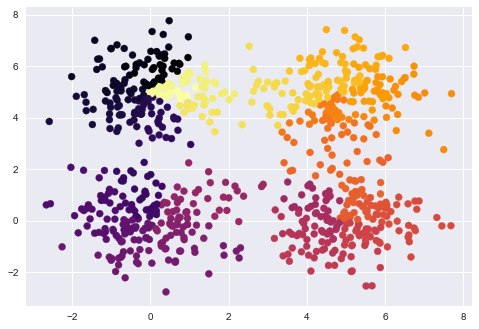

201.894517859 0.0275344180225 180.924008867 0.0250312891114


In [9]:
from matplotlib import pyplot as plt
import viz
import dataio
import TSPmeans
import LKH
import ordering
#import viz
'''
data,labels=dataio.makeBlobs(800)
datafull=data.copy()
datafull['label']=labels
datafull.to_csv('blobs.csv',index=False)
'''
data=dataio.loadData('blobs.csv',header=True,class_column='label',delete_class=True)
data.columns=range(2)
datafull=dataio.loadData('blobs.csv',header=True,class_column='label')
#datafull.columns=range(3)
#print data

#lkh_order=ordering.LKHordering(data)
lkh_order=[0, 75, 798, 624, 567, 410, 295, 235, 491, 98, 431, 503, 163, 105, 36, 165, 771, 710, 767, 562, 193, 5, 397, 326, 675, 242, 585, 595, 605, 140, 21, 170, 663, 762, 645, 646, 159, 256, 281, 514, 712, 743, 594, 48, 784, 707, 188, 125, 630, 789, 780, 172, 167, 219, 402, 389, 47, 239, 12, 137, 322, 374, 732, 721, 711, 510, 215, 237, 634, 551, 275, 184, 213, 753, 405, 10, 734, 8, 550, 91, 696, 304, 484, 196, 387, 730, 190, 67, 715, 720, 781, 305, 232, 680, 49, 247, 3, 261, 447, 308, 429, 306, 737, 467, 779, 82, 647, 777, 156, 606, 302, 507, 492, 716, 316, 555, 139, 604, 676, 277, 417, 479, 291, 770, 569, 233, 205, 258, 208, 135, 694, 185, 690, 703, 572, 119, 602, 533, 266, 323, 535, 211, 381, 222, 544, 350, 154, 674, 335, 269, 328, 621, 740, 660, 109, 9, 80, 392, 339, 353, 117, 153, 508, 609, 752, 691, 398, 416, 313, 519, 655, 25, 610, 518, 631, 672, 356, 548, 129, 72, 799, 403, 288, 593, 702, 774, 536, 221, 344, 318, 259, 578, 692, 327, 413, 147, 438, 433, 150, 244, 377, 412, 201, 456, 718, 449, 601, 234, 558, 677, 368, 236, 719, 650, 580, 103, 380, 200, 534, 11, 419, 283, 769, 24, 68, 160, 636, 528, 198, 448, 704, 748, 86, 511, 30, 521, 223, 319, 538, 524, 681, 570, 359, 118, 626, 540, 652, 454, 161, 792, 76, 589, 311, 700, 404, 226, 101, 189, 761, 451, 613, 229, 365, 255, 641, 38, 238, 500, 162, 207, 608, 19, 714, 116, 768, 520, 778, 65, 581, 369, 243, 575, 357, 16, 485, 466, 759, 446, 64, 625, 301, 108, 576, 648, 112, 352, 241, 191, 90, 385, 628, 248, 474, 63, 400, 486, 58, 559, 465, 478, 334, 527, 638, 131, 133, 373, 186, 480, 617, 588, 667, 522, 399, 202, 517, 586, 598, 633, 149, 74, 487, 758, 463, 708, 415, 662, 300, 183, 379, 60, 684, 441, 481, 155, 171, 724, 785, 18, 658, 629, 406, 455, 96, 272, 688, 705, 168, 123, 77, 99, 450, 209, 757, 445, 113, 115, 623, 20, 439, 355, 71, 228, 230, 654, 615, 320, 141, 464, 132, 443, 689, 388, 701, 425, 642, 497, 795, 62, 619, 470, 354, 411, 687, 92, 166, 174, 729, 286, 394, 424, 709, 371, 393, 46, 390, 537, 582, 61, 310, 333, 600, 764, 218, 553, 293, 423, 458, 51, 442, 790, 246, 564, 440, 176, 332, 428, 197, 81, 107, 134, 37, 83, 546, 577, 490, 216, 366, 252, 549, 324, 461, 574, 351, 97, 52, 699, 797, 53, 505, 69, 612, 314, 378, 731, 95, 622, 178, 386, 127, 728, 54, 603, 751, 348, 794, 363, 616, 349, 250, 596, 422, 590, 523, 297, 561, 554, 473, 66, 321, 683, 693, 144, 744, 102, 459, 181, 656, 659, 557, 627, 722, 697, 739, 329, 502, 664, 260, 571, 45, 325, 791, 26, 136, 169, 330, 192, 566, 263, 104, 384, 217, 504, 391, 745, 717, 13, 145, 476, 271, 44, 530, 179, 56, 110, 33, 210, 472, 513, 776, 750, 695, 666, 29, 746, 452, 227, 50, 395, 657, 469, 782, 100, 682, 182, 375, 27, 40, 203, 747, 120, 340, 462, 444, 678, 138, 501, 142, 175, 245, 494, 668, 303, 749, 796, 360, 7, 267, 278, 460, 14, 742, 249, 499, 338, 788, 204, 2, 93, 727, 299, 483, 427, 280, 57, 294, 55, 158, 122, 407, 723, 532, 32, 408, 552, 274, 289, 345, 195, 471, 88, 698, 214, 307, 224, 775, 343, 436, 545, 240, 157, 725, 584, 787, 383, 506, 337, 194, 367, 587, 515, 525, 760, 661, 639, 282, 773, 342, 783, 635, 509, 124, 206, 512, 231, 495, 225, 766, 396, 309, 735, 653, 726, 618, 640, 754, 426, 128, 475, 488, 15, 273, 643, 257, 296, 59, 152, 565, 539, 421, 287, 28, 741, 665, 17, 583, 579, 547, 111, 22, 543, 651, 733, 41, 607, 264, 84, 573, 498, 73, 529, 435, 542, 763, 336, 620, 706, 364, 199, 649, 361, 292, 89, 346, 671, 563, 276, 637, 414, 437, 317, 164, 531, 793, 772, 212, 130, 265, 755, 477, 312, 254, 670, 94, 315, 409, 679, 591, 177, 35, 253, 738, 220, 148, 87, 143, 432, 180, 418, 285, 457, 6, 597, 78, 614, 401, 632, 568, 493, 173, 382, 556, 370, 592, 121, 686, 611, 85, 331, 34, 430, 669, 1, 298, 685, 673, 341, 644, 756, 70, 468, 560, 262, 251, 106, 599, 42, 786, 284, 151, 270, 453, 114, 362, 736, 482, 420, 146, 516, 765, 4, 489, 376, 43, 713, 358, 31, 372, 187, 39, 526, 23, 126, 79, 268, 279, 347, 541, 496, 290, 434]
#print lkh_order
#tsp_order=ordering.TSPmeansordering(data)
tsp_order=[634, 169, 791, 136, 26, 192, 330, 295, 235, 491, 98, 410, 567, 624, 798, 75, 0, 434, 290, 496, 541, 347, 279, 771, 710, 165, 36, 105, 163, 503, 431, 732, 721, 711, 237, 215, 510, 551, 275, 405, 753, 184, 213, 47, 239, 12, 137, 322, 374, 402, 389, 219, 167, 172, 595, 605, 397, 193, 5, 767, 562, 326, 675, 585, 242, 126, 23, 79, 268, 31, 372, 39, 526, 140, 21, 663, 170, 125, 188, 630, 789, 780, 707, 784, 514, 762, 645, 646, 159, 256, 281, 712, 48, 594, 743, 599, 42, 786, 284, 151, 270, 453, 114, 736, 362, 516, 482, 420, 187, 358, 146, 713, 43, 376, 489, 4, 765, 747, 120, 340, 462, 40, 203, 27, 501, 142, 138, 678, 444, 106, 251, 262, 560, 468, 70, 756, 686, 121, 592, 611, 85, 331, 34, 685, 298, 1, 669, 430, 644, 341, 673, 607, 264, 84, 573, 498, 73, 529, 435, 542, 763, 336, 755, 477, 312, 254, 670, 94, 315, 143, 409, 87, 148, 220, 738, 253, 35, 177, 591, 679, 556, 370, 382, 173, 493, 568, 632, 401, 614, 78, 597, 6, 285, 432, 180, 418, 457, 525, 515, 760, 661, 342, 773, 282, 639, 124, 509, 635, 783, 414, 437, 637, 276, 563, 671, 346, 292, 361, 89, 317, 164, 531, 793, 772, 212, 265, 130, 620, 706, 364, 199, 649, 766, 225, 396, 495, 231, 512, 206, 157, 725, 584, 787, 383, 194, 367, 587, 337, 506, 57, 280, 427, 55, 294, 240, 545, 436, 158, 122, 532, 407, 723, 483, 299, 727, 93, 2, 204, 788, 274, 552, 408, 32, 775, 343, 224, 307, 214, 698, 88, 471, 195, 345, 289, 499, 338, 742, 249, 488, 475, 128, 426, 257, 726, 618, 754, 640, 309, 735, 653, 296, 643, 273, 15, 28, 287, 421, 539, 565, 152, 59, 41, 733, 651, 543, 22, 111, 547, 579, 741, 665, 583, 17, 175, 245, 494, 668, 303, 749, 796, 360, 7, 278, 267, 14, 460, 69, 612, 314, 238, 38, 500, 162, 505, 699, 52, 97, 243, 369, 581, 207, 520, 768, 116, 608, 19, 714, 684, 778, 65, 575, 357, 16, 485, 466, 759, 446, 64, 625, 428, 197, 37, 83, 134, 107, 81, 216, 366, 490, 252, 549, 324, 461, 574, 351, 53, 797, 424, 709, 371, 393, 46, 390, 537, 582, 577, 546, 293, 553, 218, 764, 600, 333, 310, 61, 286, 394, 729, 174, 166, 92, 687, 411, 458, 423, 51, 470, 354, 619, 62, 795, 334, 478, 790, 442, 246, 564, 440, 176, 332, 301, 108, 576, 248, 474, 63, 400, 58, 486, 617, 588, 667, 399, 522, 480, 186, 373, 559, 465, 133, 131, 638, 527, 497, 642, 425, 701, 388, 689, 443, 132, 464, 141, 320, 615, 654, 230, 228, 71, 355, 439, 598, 586, 517, 202, 487, 74, 149, 633, 20, 623, 115, 113, 757, 445, 209, 450, 99, 123, 77, 183, 300, 662, 415, 708, 463, 758, 628, 191, 90, 385, 648, 112, 352, 241, 60, 379, 441, 481, 155, 658, 18, 785, 724, 171, 168, 705, 339, 392, 353, 688, 272, 96, 455, 629, 406, 613, 641, 731, 378, 95, 255, 229, 365, 451, 117, 153, 761, 189, 622, 178, 386, 101, 226, 752, 691, 609, 508, 660, 740, 621, 416, 398, 404, 700, 311, 76, 792, 589, 348, 751, 127, 54, 603, 794, 363, 30, 521, 129, 72, 799, 403, 548, 223, 319, 538, 524, 118, 359, 570, 681, 161, 626, 540, 454, 652, 313, 519, 655, 328, 269, 154, 674, 335, 109, 9, 80, 291, 770, 569, 233, 205, 258, 208, 135, 694, 185, 479, 417, 690, 703, 572, 119, 602, 533, 266, 323, 535, 211, 381, 222, 544, 350, 25, 610, 518, 631, 672, 356, 344, 221, 318, 259, 578, 692, 327, 413, 147, 302, 606, 507, 492, 716, 316, 676, 277, 604, 139, 555, 737, 779, 467, 306, 429, 308, 447, 82, 647, 261, 3, 305, 232, 781, 720, 680, 247, 49, 777, 156, 456, 201, 718, 449, 412, 377, 438, 244, 150, 433, 288, 593, 702, 774, 536, 601, 234, 558, 677, 368, 715, 67, 190, 236, 719, 650, 580, 103, 380, 200, 534, 11, 419, 283, 769, 24, 68, 160, 528, 636, 511, 86, 748, 616, 704, 198, 349, 250, 596, 422, 728, 590, 523, 297, 448, 730, 387, 196, 484, 304, 10, 734, 8, 550, 696, 91, 561, 554, 473, 66, 693, 683, 321, 375, 657, 782, 469, 182, 682, 100, 656, 659, 557, 722, 627, 181, 144, 744, 102, 459, 502, 664, 260, 329, 739, 571, 45, 325, 566, 263, 104, 384, 217, 504, 391, 745, 717, 13, 145, 476, 271, 44, 530, 179, 56, 110, 33, 210, 472, 513, 776, 750, 695, 666, 29, 746, 452, 395, 50, 227, 697]
#print tsp_order
viz.plotDataFrame(plt,data,tsp_order,3,by_number=True,with_line=False)
plt.savefig('tsp-blobs.png')

#print_df=datafull.transpose()

#print datafull[2]==0
#df1=datafull.loc[datafull[2]==0,:]
#df2=datafull.loc[datafull[2]==1,:]
#df3=datafull.loc[datafull[2]==2,:]
#df4=datafull.loc[datafull[2]==3,:]

#print df1
#viz.plotDataFrame(plt,datafull,None,3,by_number=True,with_line=False,by_class=True)
#plt.savefig('label-blobs.png')
"""

tsp_order=ordering.TSPmeansordering(data)
viz.plotDataFrame(plt,data,lkh_order,1,by_number=True,with_line=False)
"""    
plt.show()

length_tsp=metrics.calculateTourLength(data,tsp_order)
length_lkh=metrics.calculateTourLength(data,lkh_order)

fom_tsp=metrics.calculateFOM(dataio.getOrderedDF(datafull,tsp_order),'label')
fom_lkh=metrics.calculateFOM(dataio.getOrderedDF(datafull,lkh_order),'label')

print length_tsp, fom_tsp, length_lkh, fom_lkh

In [51]:
import pandas as pd
import numpy as np

def convertOrderToIndex(order):
    #return list with position of the element concerning order
    n=len(order)
    new_order=[-1 for i in range(n)]
    
    for i in range(n):
        new_order[order[i]]=i
        
    #print order
    #print new_order
    return new_order

def getOrderedDF(data,order):

    converted_order=convertOrderToIndex(order)
    order_df=pd.DataFrame({'order':converted_order},index=data.index.tolist())
    
    #print order_df

    output_df=pd.concat([data,order_df],axis=1)
    output_df.sort_values('order', inplace=True)
    
    #print output_df.head()
    
    output_df.drop('order',axis=1,inplace=True)
    
    #print output_df.head()
    
    return output_df

def calculateSigma(data,order):
    n=data.shape[0]
    m=data.shape[1]
    
    if order==None:
        order=range(0,n)
        
    #print 'Order',order
    
    sigma=np.zeros(m)
    data_ordered=getOrderedDF(data,order)
    values_ordered=data_ordered.values
    
    if n<2:
        print 'Cannot calculate Sigmas with one example'
        return sigma
    
    diff_arr=(values_ordered[0:n-1,:]-values_ordered[1:n,:])
    sigma_squared=np.sum(diff_arr**2,axis=0)
    sigma=np.sqrt(sigma_squared)/(n-1)
    
    sigmadf=pd.DataFrame([sigma],columns=range(0,m))
    
    return sigmadf

def calculateEntropy_old(data,sigma,order=None):
    n=data.shape[0]
    m=data.shape[1]
    
    if order==None:
        order=range(0,n)
        
    sigma_list= sigma.values[0]
    
    #scaled_data=scaleData(data, sigma)
     
    sum_r=0
    for j in range(0,m):
        #calculate right part
        for i in range (1,n):
            sum_r+=(data.loc[order[i],j]-data.loc[order[i-1],j])**2/sigma_list[j]**2
    sum_r=sum_r/(2*(n-1))

    sum_l=0
    for j in range(0,m):
        sum_l+=np.log(sigma_list[j])
    sum_l+=m*np.log(2*np.pi)
    sum_l=n*sum_l/(2*(n-1))
    
    #print sum_r,sum_l
    
    result=sum_r+sum_l
    
    return result

def calculateEntropy(data,sigma,order):
    n=data.shape[0]
    m=data.shape[1]
    
    if order==None:
        order=range(0,n)
        
    values_ordered=getOrderedDF(data,order).values
    diff_arr=((values_ordered[0:n-1,:]-values_ordered[1:n,:])/sigma.values)**2
    sum_r=np.sum(diff_arr)/(2*(n-1))


    sum_l=np.sum(np.log(sigma.values))
    sum_l+=m*np.log(2*np.pi)
    sum_l=n*sum_l/(2*(n-1))
    
    return sum_r+sum_l

df=pd.DataFrame({0:[1,2,3,4,5],1:[3,5,7,9,8],2:[8,5,4,7,3]})
n=df.shape[0]
m=df.shape[1]

print df

order=range(n)
order=[4,3,1,2,0]
sigma=calculateSigma(df,order)

print sigma

print calculateEntropy_old(df,sigma,order)
print calculateEntropy(df,sigma,order)




   0  1  2
0  1  3  8
1  2  5  5
2  3  7  4
3  4  9  7
4  5  8  3
          0         1         2
0  0.790569  1.520691  1.520691
9.82309910938
9.82309910938


In [1]:
import numpy as np
import random
import sklearn.metrics.pairwise
import scipy.spatial.distance

r = np.array([random.randrange(1, 1000) for _ in range(0, 1000)])
c = r[:, None]

def option1(r):
    dists = np.abs(r - r[:, None])

def option2(r):
    dists = scipy.spatial.distance.pdist(r, 'euclidian')

def option3(r):
    dists = sklearn.metrics.pairwise.euclidean_distances(r)

In [8]:
timeit option1(r)

100 loops, best of 3: 4.01 ms per loop


In [9]:
timeit option2(c)

1000 loops, best of 3: 1.86 ms per loop


In [10]:
timeit option3(c)

100 loops, best of 3: 3.86 ms per loop


   X1  Y1
0   1   3
1   2   4
2   3   6
3   4   2
4   5   5
5   6   4


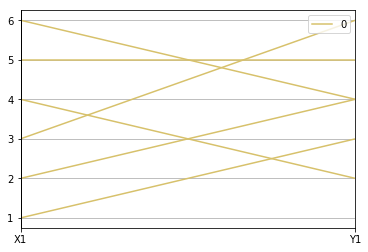

    X1  Y1  label  X2  Y2
3    1   3      0   4   2
9    2   4      0   4   2
15   3   6      0   4   2
16   3   6      0   5   5
17   3   6      0   6   4
29   5   5      0   6   4


In [28]:
import pandas as pd
df=pd.DataFrame({'X1':[1,2,3,4,5,6],'Y1':[3,4,6,2,5,4]})
print(df)

from pandas.plotting import parallel_coordinates
from matplotlib import pyplot as plt
df['label']=0
parallel_coordinates(df,class_column='label')
plt.show()

df2=df.copy()
df2.columns=['X2','Y2','label']
df4=df.merge(df2,how='outer')
df5=df4.loc[(df4.X1<df4.X2) & (df4.Y1>df4.Y2)]
print(df5)

In [8]:
import pandas as pd
df=pd.read_csv('gas_sensors.csv',delimiter=',',header=0)
#df.drop('0',axis=1,inplace=True)

#df.loc[df.sex=='M','sex']=0
#df.loc[df.sex=='F','sex']=1
#df.loc[df.sex=='I','sex']=2
#df=pd.concat([df1,df2],axis=0)
df.loc[:,'id']=df['id'].astype(int)
#df=df[['time','R1','R2','R3','R4','R5','R6','R7','R8','Temperature','Humidity','id']]
print(df.shape)

df.to_csv('gas_sensors.csv',index=False)

(928991, 12)


In [21]:
import numpy as np

n=7
m=5
w=2


matrix=np.matrix(range(1,36))
matrix.shape=(n,m)

print(matrix)

extended_matrix=np.zeros((n+w*2,m+w*2))
    
extended_matrix[w:(n+w),w:(m+w)]=matrix
extended_matrix[0:w,:]=extended_matrix[n:n+w,:]
extended_matrix[n+w:n+w*2,:]=extended_matrix[w:w*2,:]
extended_matrix[:,0:w]=extended_matrix[:,m:m+w]
extended_matrix[:,m+w:m+w*2]=extended_matrix[:,w:w*2]
print(extended_matrix)

[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 18 19 20]
 [21 22 23 24 25]
 [26 27 28 29 30]
 [31 32 33 34 35]]
[[ 29.  30.  26.  27.  28.  29.  30.  26.  27.]
 [ 34.  35.  31.  32.  33.  34.  35.  31.  32.]
 [  4.   5.   1.   2.   3.   4.   5.   1.   2.]
 [  9.  10.   6.   7.   8.   9.  10.   6.   7.]
 [ 14.  15.  11.  12.  13.  14.  15.  11.  12.]
 [ 19.  20.  16.  17.  18.  19.  20.  16.  17.]
 [ 24.  25.  21.  22.  23.  24.  25.  21.  22.]
 [ 29.  30.  26.  27.  28.  29.  30.  26.  27.]
 [ 34.  35.  31.  32.  33.  34.  35.  31.  32.]
 [  4.   5.   1.   2.   3.   4.   5.   1.   2.]
 [  9.  10.   6.   7.   8.   9.  10.   6.   7.]]


In [30]:
n=100
w=0.043*n+0.3
print(w)

4.6


In [ ]:
datasets_all=dataio.sources_dict.keys()
ordering_methods_all=['TSNE','random','TSPmeans','EM','EMmanhattan','HColo','LK','MDS']

for dataset_name in datasets_all:
    #try:
    
    if dataset_name=='parkinson':
        alias='parkinsons'
    elif dataset_name=='community':
        alias='communities'
    elif dataset_name=='olive':
        alias='oliveoil'   
    elif dataset_name=='noisy_wave':
        alias='waveform_noise'  
    elif dataset_name in ('golub','traffic','alon','iris','wdbc','yeast','cars','abalone','income'):
        continue
    else:
        alias=dataset_name
    output_name=output_dir+alias+'/'+alias
        

    print 'Working with dataset:',dataset_name

    #check and create folder
    directory = output_dir+dataset_name
    #print directory
    if not os.path.exists(directory):
        os.makedirs(directory)

    viz_method='SPLOM'
    params={
        'data_source_type':'load',
        'data_source':alias,
        }
    params=dataio.setDatasetParams(params)
    class_column=params['class_column']
    scale_columns=params['scale_columns']
    
    print output_name
    
    for index,ordering in enumerate(ordering_methods_all):
        print ordering
        csv_cols = output_name+'_'+ordering+'_cols.csv'
        df_cols=dataio.loadData(csv_cols,header=True,class_column=class_column)
        #print df_cols.head()
        outpng = os.path.join(output_name+'_'+ordering+'_'+viz_method+'.png')
        viz.visualizeData(viz_method,df_cols,outpng,ordering,index,class_column,scale_columns)  
                

Working with dataset: aaup
E:/Master-thesis/output/evaluation/aaup/aaup
TSNE
random
